## Introduction to Machine Learning: Supervised Learning Final Project

### My GitHub repository for this project:  
https://github.com/Sean-Diab/CU-Boulder-MSCS/tree/main/CSCA-5622-Supervised-Learning-Final-Project

For this final project I have decided to attempt to predict how the revenue of a movie based on certain factors.

##### Imports:

In [1]:
import csv
import time
import requests
from dotenv import load_dotenv
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

#import winsound #Optional


#### Step 1: Collect the data

I downloaded a csv file that has the TMDB (The Movie Database) IDs of around 45000 movies from this Kaggle [dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data?select=links.csv). Here is what the data looks like:

movieId,imdbId,tmdbId  
1,0114709,862  
2,0113497,8844  
3,0113228,15602

I need to create an array of just the TMDB IDs

In [2]:
tmdb_ids = []

with open('Data/links.csv', mode='r') as file:
    reader = csv.DictReader(file)

    for row in reader:
        tmdb_ids.append(row['tmdbId'])
    
print(tmdb_ids[:10]) #Print the first 10 IDs

['862', '8844', '15602', '31357', '11862', '949', '11860', '45325', '9091', '710']


Now we can use the TMDB API to extract data for each movie ID.

I did this by saving the data to a jsonl file (JSON Lines) file. I chose this approach because I had trouble going through the entire 45000 movies list without getting some error with connection to their servers. Whenever there would be a single error the entire previous data was wiped, so I decided to make this new approach by update a jsonl file every 100 movies instead of all at once.

Some movies in the data that I downloaded did not have a TMDB ID, so I saved their indices to the 'bad_indices.jsonl' file so I knew exactly which ones they were.

## Important!
In order to run this yourself you need your own free TMDB API key, You can get one here: https://www.themoviedb.org. Once you have your api key update this line in the .env file with your api key: TMDB_API_KEY='your_api_key'

In [3]:
load_dotenv()
api_key = os.getenv("TMDB_API_KEY")
base_url = "https://api.themoviedb.org/3/movie/"

# Initialize containers for batch writing
movie_data_batch = []
bad_indices_batch = []

# Loop through each movie ID, fetch data, and batch write every 100 records

#To get the full file you would iterate through all the data, but there are over 45000 ids, so it took me hours to get the full data.
#If you want to try it out to see how it works I'd recommend just doing a few hundred data points.

#for i in range(len(tmdb_ids)): #Use this for loop for the full data. It took me roughly 2 hours to fully run
for i in range(130):
    movie_id = tmdb_ids[i]
    url = f"{base_url}{movie_id}?api_key={api_key}"

    try:
        response = requests.get(url, timeout=5)
        
        if response.status_code == 200:
            data = response.json()
            movie_info = {
                'id': data['id'],
                'title': data['title'],
                'budget': data['budget'],
                'revenue': data['revenue'],
                'release_date': data['release_date'],
                'popularity': data['popularity'],
                'vote_average': data['vote_average'],
                'vote_count': data['vote_count'],
                'genres': [genre['name'] for genre in data['genres']],
                'runtime': data['runtime'],
                'production_companies': [company['name'] for company in data['production_companies']],
                'production_countries': [country['name'] for country in data['production_countries']],
            }
            
            #Add movie info to the batch
            movie_data_batch.append(movie_info)
        
        else:
            #Add the index of a failed request to the bad indices batch
            bad_indices_batch.append(i)

    except requests.exceptions.Timeout:
        print(f"Timeout occurred for movie ID {movie_id} at index {i}")
        #Add the index of a timed-out request to the bad indices batch
        bad_indices_batch.append(i)
        time.sleep(1)  # Optional: wait 1 second before continuing

    except requests.exceptions.RequestException as e:
        #Add the index of any other request exception to the bad indices batch
        bad_indices_batch.append(i)

    #Write batches to files every 100 records
    if i % 100 == 0 and i != 0:
        print(f'{i} out of {len(tmdb_ids)}')

        #Write movie data batch to JSON Lines file
        with open('movie_data.jsonl', 'a') as json_file:
            for movie in movie_data_batch:
                json_file.write(json.dumps(movie) + '\n')
        
        #Write bad indices batch to JSON Lines file
        with open('bad_indices.jsonl', 'a') as bad_file:
            for index in bad_indices_batch:
                bad_file.write(json.dumps(index) + '\n')
        
        #Clear the batches after writing
        movie_data_batch.clear()
        bad_indices_batch.clear()

#Write any remaining data if the loop ends before reaching a batch of 100
if movie_data_batch:
    with open('movie_data.jsonl', 'a') as json_file:
        for movie in movie_data_batch:
            json_file.write(json.dumps(movie) + '\n')

if bad_indices_batch:
    with open('bad_indices.jsonl', 'a') as bad_file:
        for index in bad_indices_batch:
            bad_file.write(json.dumps(index) + '\n')


print("Data fetching complete.")
#winsound.Beep(1000, 500)  #A beep to let me know it's done

100 out of 45843
Data fetching complete.


I noticed that a lot of the data had missing values, so I ran this script to remove all movies with missing values and save it to a file called clean_movie_data:

In [4]:
required_fields = [
    'id', 'title', 'budget', 'revenue', 'release_date', 
    'popularity', 'vote_average', 'vote_count', 
    'genres', 'runtime', 'production_companies', 'production_countries'
]


#Open the input file and a new output file for cleaned data
with open('Data/movie_data.jsonl', 'r', encoding='utf-8') as infile, open('clean_movie_data.jsonl', 'w', encoding='utf-8') as outfile:
    for line in infile:
        movie = json.loads(line.strip())
        
        #Check if the movie entry has all required fields with non-empty values
        if all(movie.get(field) for field in required_fields):
            # rite the entry to the output file if it has full data
            outfile.write(json.dumps(movie) + '\n')

This saves the data into a jsonl file called 'clean_movie_data.jsonl'.  
Here is what the end result looks like (Sample of 2 movies out of 7911):

In [5]:
#{"id": 862, "title": "Toy Story", "budget": 30000000, "revenue": 394436586, "release_date": "1995-10-30", "popularity": 115.812, "vote_average": 7.971, "vote_count": 18322, "genres": ["Animation", "Adventure", "Family", "Comedy"], "runtime": 81, "production_companies": ["Pixar"], "production_countries": ["United States of America"]}
#{"id": 8844, "title": "Jumanji", "budget": 65000000, "revenue": 262821940, "release_date": "1995-12-15", "popularity": 17.805, "vote_average": 7.2, "vote_count": 10466, "genres": ["Adventure", "Fantasy", "Family"], "runtime": 104, "production_companies": ["TriStar Pictures", "Interscope Communications", "Teitler Film", "PolyGram Filmed Entertainment"], "production_countries": ["United States of America"]}

The data collection is complete, we can now start our exploratory data analysis.  
# EDA

Let's load the data into a pandas DataFrame

In [6]:
file_path = 'Data/clean_movie_data.jsonl'
df = pd.read_json(file_path, lines=True)

df.head()

,id,title,budget,revenue,release_date,popularity,vote_average,vote_count,genres,runtime,production_companies,production_countries
0,862,Toy Story,30000000,394436586,1995-10-30,115.812,7.971,18322,"[Animation, Adventure, Family, Comedy]",81,[Pixar],[United States of America]
1,8844,Jumanji,65000000,262821940,1995-12-15,17.805,7.200,10466,"[Adventure, Fantasy, Family]",104,"[TriStar Pictures, Interscope Communications, ...",[United States of America]
2,15602,Grumpier Old Men,25000000,71500000,1995-12-22,13.189,6.500,375,"[Romance, Comedy]",101,"[Lancaster Gate, Warner Bros. Pictures]",[United States of America]
3,31357,Waiting to Exhale,16000000,81452156,1995-12-22,21.462,6.300,162,"[Comedy, Drama, Romance]",127,[20th Century Fox],[United States of America]
4,949,Heat,60000000,187400000,1995-12-15,57.120,7.900,7258,"[Action, Crime, Drama]",170,"[Warner Bros. Pictures, Regency Enterprises, F...",[United States of America]


Let's first check to make sure that all the data types are correct

In [7]:
# Define the expected data types for each field
expected_types = {
    "id": int,
    "title": str,
    "budget": int,
    "revenue": int,
    "release_date": str,  # We'll check if it's in date format separately
    "popularity": float,
    "vote_average": float,
    "vote_count": int,
    "genres": list,
    "runtime": int,
    "production_companies": list,
    "production_countries": list
}


issues = []
print("Starting data type check...\n")

for col, expected_type in expected_types.items():
    print(f"Checking column: '{col}'")

    if col in df.columns:
        print(f"  Column '{col}' exists. Expected type: {expected_type.__name__}")
        
        #Check if the entire column is of the expected type
        type_issues = False
        for index, val in df[col].dropna().items():
            if not isinstance(val, expected_type):
                print(f"    Type issue found at index {index} in column '{col}'. Value: {val} (Type: {type(val).__name__})")
                type_issues = True
                issues.append(f"Column '{col}' has values that do not match the expected type {expected_type.__name__}.")
                break

        if not type_issues:
            print(f"  All values in column '{col}' match the expected type.\n")
        
        # Special handling for release_date to check for valid date format
        if col == "release_date" and df[col].dtype == 'O':  # 'O' denotes object type
            print(f"  Checking date format for column '{col}'")
            date_issues = False
            for index, date_str in df[col].dropna().items():
                try:
                    pd.to_datetime(date_str, format='%Y-%m-%d')
                except ValueError:
                    print(f"    Date format issue at index {index} in column '{col}'. Value: {date_str}")
                    date_issues = True
                    issues.append(f"Column 'release_date' contains invalid date formats.")
                    break

            if not date_issues:
                print(f"  All values in column '{col}' have a valid date format.\n")
    else:
        print(f"  Column '{col}' is missing from the DataFrame.")
        issues.append(f"Column '{col}' is missing from the DataFrame.")

print("\nData type check completed.\n")

if issues:
    print("Data Type Issues Found:")
    for issue in issues:
        print(issue)
else:
    print("All data types are correct.")


Starting data type check...

Checking column: 'id'
  Column 'id' exists. Expected type: int
  All values in column 'id' match the expected type.

Checking column: 'title'
  Column 'title' exists. Expected type: str
  All values in column 'title' match the expected type.

Checking column: 'budget'
  Column 'budget' exists. Expected type: int
  All values in column 'budget' match the expected type.

Checking column: 'revenue'
  Column 'revenue' exists. Expected type: int
  All values in column 'revenue' match the expected type.

Checking column: 'release_date'
  Column 'release_date' exists. Expected type: str
  All values in column 'release_date' match the expected type.

  Checking date format for column 'release_date'
  All values in column 'release_date' have a valid date format.

Checking column: 'popularity'
  Column 'popularity' exists. Expected type: float
  All values in column 'popularity' match the expected type.

Checking column: 'vote_average'
  Column 'vote_average' exists.

Now let's get a better understanding of the data. We'll start by calculating the mean, median, etc. for the numerical columns.

In [8]:
numerical_columns = ["budget", "revenue", "popularity", "vote_average", "vote_count", "runtime"]

summary_stats = df[numerical_columns].describe().T  # Transpose for readability
summary_stats = summary_stats.round(0).astype(int) #Round and get rid of scientific notation
summary_stats = summary_stats.map(lambda x: f"{x:,}") #Add commas to make big numbers more readable


print("Summary Statistics for Numerical Columns:")
print(summary_stats)

Summary Statistics for Numerical Columns:
              count        mean          std min        25%         50%  \
budget        7,911  24,820,386   35,606,382   1  4,000,000  12,000,000   
revenue       7,911  68,887,873  146,351,668   1  3,979,096  18,253,415   
popularity    7,911          24           22   0         11          18   
vote_average  7,911           6            1   2          6           6   
vote_count    7,911       1,791        3,268   1        173         591   
runtime       7,911         109           21   5         94         105   

                     75%            max  
budget        30,000,000    460,000,000  
revenue       67,119,730  2,923,706,026  
popularity            29            334  
vote_average           7              9  
vote_count         1,823         36,512  
runtime              118            339  


That's pretty interesting! Just out of curiosity, let me see which movie made ~3 billion dollars in revenue

In [9]:
max_revenue_movie = df[df['revenue'] == 2923706026]
print(max_revenue_movie[['title', 'revenue', 'release_date']])

       title     revenue release_date
5278  Avatar  2923706026   2009-12-15


That was a good movie. Let's make some remarks about the statistics:

-The average budget is around $24.8 million and has a high standard deviation of $35.6 million, which indicates a very high range in budgets, especially since the standard deviation is remarkably higher than the mean.  
-Since the median budget is $12 million and 75% of movies have a budget of $30 million or less, it suggests that a small amount of movies skew the average upwards.

-We can notice a similar thing about the revenue: a noticably higher standard deviation than the mean, suggesting high variability.

-The average popularity score is 24, but the standard deviation is 22, which indicates that some movies have extremely high popularity scores compared to the average

-The ratings seems pretty consistent, with the average rating being 6.4 and a relatively low standard deviation of 1

Let's see which movie had the highest popularity score:

In [10]:
most_popular_movie = df.loc[df['popularity'].idxmax()]
print(most_popular_movie[['title', 'revenue', 'release_date']])

title            Gladiator
revenue          465361176
release_date    2000-05-04
Name: 1863, dtype: object


I haven't seen Gladiatory yet, I'll watch it tonight!

Now let's make histograms for budget, revenue, and popularity to visualize the data.

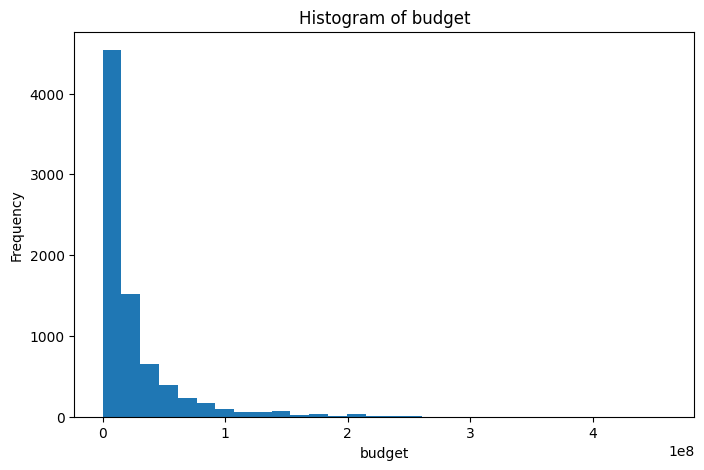

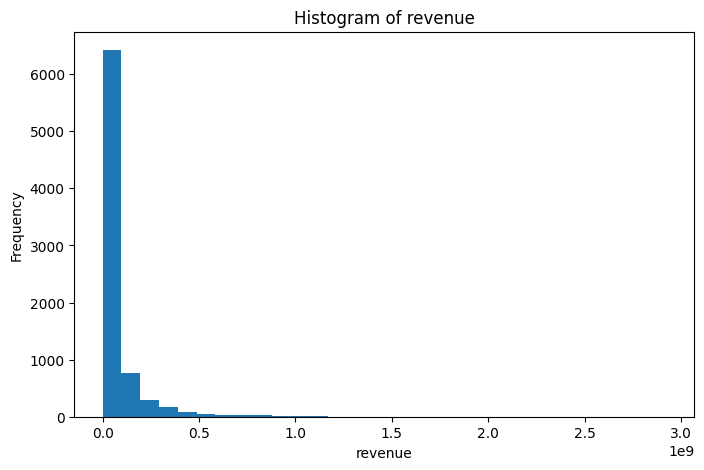

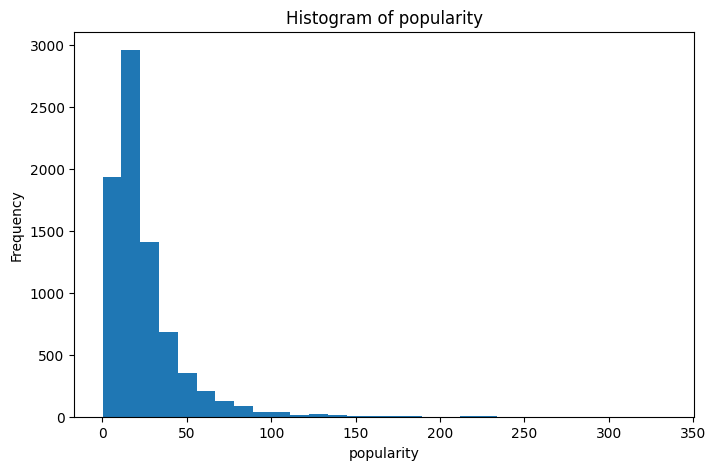

In [11]:
columns_to_plot = ["budget", "revenue", "popularity"]


for col in columns_to_plot:
    plt.figure(figsize=(8, 5))
    plt.hist(df[col].dropna(), bins=30)  # Drop NaNs to avoid issues in plotting
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

As we transition into building a supervised learning model, let's look at the correlation plot to identify potential relationships between features.

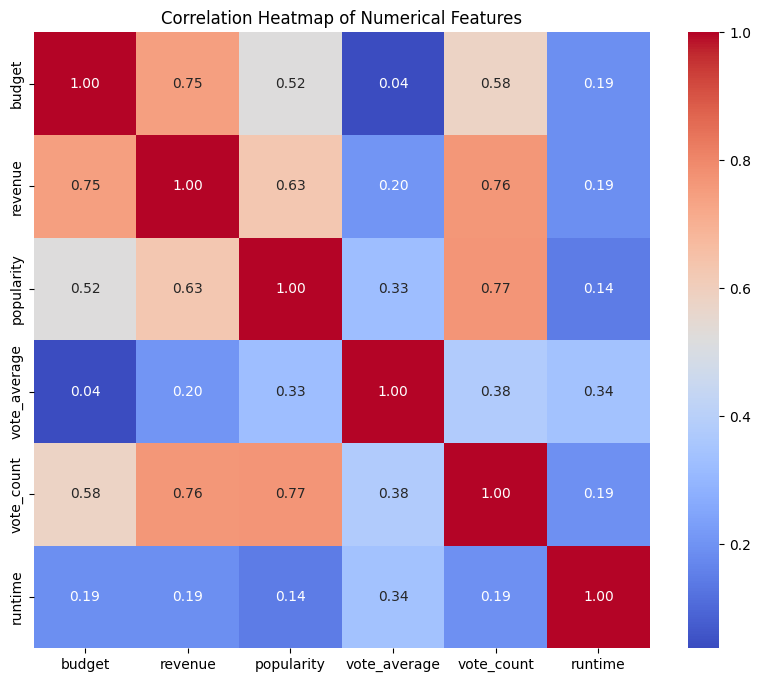

In [12]:
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

We can see that features like budget, popularity, and vote_count seem to correlate strongly to revenue, which we are trying to predict. Since it seems like the budget, popularity, and vote_count are the most important features by far and including more features might introduce too many unneccesary dimensions, let's only include those in our data (alongside the title)  
This code saves only 'title', 'budget', 'popularity', 'vote_count', 'revenue' to a new file called final_movie_data

In [13]:
df_final = df[['title', 'budget', 'popularity', 'vote_count', 'revenue']]
df_final = df_final.dropna()

print("Cleaned Data:")
print(df_final)

df_final.to_csv('final_movie_data.csv', index=False)

Cleaned Data:
                                         title     budget  popularity  \
0                                    Toy Story   30000000     115.812   
1                                      Jumanji   65000000      17.805   
2                             Grumpier Old Men   25000000      13.189   
3                            Waiting to Exhale   16000000      21.462   
4                                         Heat   60000000      57.120   
...                                        ...        ...         ...   
7906                   The Fate of the Furious  250000000      80.029   
7907  Captain Underpants: The First Epic Movie   38000000      51.611   
7908                                  Band Aid   10000000       9.324   
7909                         It Comes at Night    5000000      14.225   
7910                                    Cars 3  175000000      86.416   

      vote_count     revenue  
0          18322   394436586  
1          10466   262821940  
2            375

## Building Supervised Learning Models

I have decided to use three methods: Random Forest Regressor, Gradient Boosting Regressor, and Linear Regression. I chose a them because the methods can capture complex relationships between the features and the target. This is especially useful in my dataset, since there are very complicated and intricate relationships between certain features and how well a movie is going to do. I chose Linear Regression because I wanted to see how these more complicated models would do against a simpler one.


##### Setting up the Variables

In [14]:
features = ['budget', 'popularity', 'vote_count']
target = 'revenue'

X = df_final[features]
y = df_final[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Regressor

In [15]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2 Score): {r2}")

# Hyperparameter Tuning with RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_rf_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Evaluate the best model on the test set
y_pred_best = best_rf_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Optimized Mean Absolute Error (MAE): {mae_best}")
print(f"Optimized R-squared (R2 Score): {r2_best}")

absolute_errors_best = np.abs(y_test - y_pred_best)
median_absolute_error_best = np.median(absolute_errors_best)
print(f"Optimized Median Absolute Error: {median_absolute_error_best}")

Mean Absolute Error (MAE): 36419862.610309534
R-squared (R2 Score): 0.7579376045191422
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': True}
Optimized Mean Absolute Error (MAE): 35186864.632392906
Optimized R-squared (R2 Score): 0.7545467916896331
Optimized Median Absolute Error: 14117142.825780846


I decided to do hyperparameter turning and pick the best model after randomly searching the parameter space, testing 20 different combinations. Here were my results:

Mean Absolute Error (MAE): 35,186,864  
Median Absolute Error: 14,117,142  
R-squared (R2 Score): 0.7545467916896331

#### XGBoost Regressor

In [16]:
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2 Score): {r2}")

# Hyperparameter Tuning with RandomizedSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

y_pred_best = best_xgb_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Optimized Mean Absolute Error (MAE): {mae_best}")
print(f"Optimized R-squared (R2 Score): {r2_best}")

absolute_errors_best = np.abs(y_test - y_pred_best)
median_absolute_error_best = np.median(absolute_errors_best)
print(f"Optimized Median Absolute Error: {median_absolute_error_best}")

Mean Absolute Error (MAE): 37001306.894652165
R-squared (R2 Score): 0.7149697542190552
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Optimized Mean Absolute Error (MAE): 34807785.63850284
Optimized R-squared (R2 Score): 0.7556353807449341
Optimized Median Absolute Error: 14146072.0


Doing a similar thing for the XGBoost Regressor, here were my results:

Mean Absolute Error (MAE): 34,807,785  
Median Absolute Error: 14146072  
R-squared (R2 Score): 0.7556353807449341  

For fun, I decided to fit a linear regression model to the data to see how well it would do compared to the other more advanced methods.

In [17]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2 Score): {r2}")

coefficients = pd.DataFrame({'Feature': features, 'Coefficient': linear_model.coef_})
print("Feature Coefficients:")
print(coefficients)

absolute_errors = np.abs(y_test - y_pred)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Mean Absolute Error (MAE): 40286811.655076556
R-squared (R2 Score): 0.7042155464769719
Feature Coefficients:
      Feature    Coefficient
0      budget       1.810899
1  popularity  235727.505925
2  vote_count   21019.845245
Median Absolute Error: 18466363.278620634


My results:

Mean Absolute Error (MAE): 40,286,811  
Median Absolute Error: 18466363    
R-squared (R2 Score): 0.7042155464769719

## Discussion

Here is a summary of my best results for each method:

Random Forest Regressor:  
MAE: 35,186,864  
Median Absolute Error: 14,117,142  
R-squared: 0.754  

XGBoost:  
MAE: 34807785  
Median Absolute Error: 14146072  
R-squared: 0.755  

Linear Regression:  
MAE: 40,286,811  
Median Absolute Error: 18466363    
R-squared: 0.704

My best method was the XGBoost, but the Random Forest Regressor came close. It might seem like the MAE is off by a lot, since it is almost 35 million, but I would say these are quite good results. Reflecting back to the graph of revenue, we can see a very large variation. The statistics back it up, since we had a mean of 68,887,873 but an extremely large standard deviation of 146,351,668. This means if a movie comes along that unsuspectingly does very well and the model doesn't know this, it could easily be off by hundreds of millions in its prediction. We can prove this suspicion by noticing that the median absolute error is less than half of the mean absolute error. This means that the main error happened from outliers, while the majority of the error wasn't that bad. The model is trying to predict a very complicated market that is influenced by many real-world factors. For these reasons, I am very content with the results of my models.

## Conclusion:

In this project, I explored the factors that contribute to movie revenue by developing supervised learning algorithms that predict the revenue of a movie. I downloaded TMDB IDs for movies, and using those I downloaded data, cleaned, and analyzed it. I used the models XGBoost, Random Forest, and Linear Regression to predict the revenue of movies. From these models, XGBoost made the most accurate predictions by achieving the highest accuracy and the lowest mean absolute error. I am impressed with how accurately my results were able to model a complicated market. Perhaps if Isaac Newton had access to supervised learning, he would have never said "I can calculate the motion of heavenly bodies, but not the madness of people."
